## W51_e2w Modelling



### The data

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt

folder = './data/'
hdu45 = fits.open(folder+'W51e2w_VLA_Q_cutout.fits')[0] #45 GHz
hdu95 = fits.open(folder+'W51e2w_ALMAB3_cutout.fits')[0] #95 GHz

fig, ax = plt.subplots(ncols = 2, figsize = (12,10))
ax[0].set_title('Data - 45 GHz')
ax[0].imshow(hdu45.data, origin='lower')
ax[1].set_title('Data - 95 GHz')
ax[1].imshow(hdu95.data, origin='lower')
for axi in ax: fig.colorbar(axi.images[0], ax=axi, orientation='horizontal')


### Preamble

In [2]:
from __future__ import print_function
import runpy
import os, sys, subprocess
import shutil
import time
import numpy as np

from sf3dmodels import (Model, Plot_model as Pm)
from sf3dmodels.grid import Overlap
import sf3dmodels.utils.units as u
import sf3dmodels.rt as rt

t0 = time.time()

#Plotting 3-D grid points?                                                                                                                                                           
plot_3d = True

#**********************************                                                                                                                                                  
#SETTING DEFAULTS FOR RADMC-3D                                                                                                                                                       
#**********************************                                                                                                                                                  
nthreads = 4
files_ff = lambda R, prop: R.freefree(prop,
                                      kwargs_control = {'setthreads': nthreads},
                                      kwargs_wavelength = {'lam': [5e2,2e4,4e4,3e5],
                                                           'nxx': [20,20,20]})
''' 
About the lambda function 'files_ff':
- R is an instance of the class rt.Radmc3dDefaults
- prop is a dictionary with the physical properties needed for free-free calculations. 
- in kwargs_wavelength:                                                                                                                                                                
  lam: wavelength intervals in microns, 
  nxx: num of partitions in each interval                                                                                                        
''';

#*******************
#External commands
#*******************

cmd_check_call = lambda S: subprocess.check_call(S, shell=True)
cmd_call = lambda S: subprocess.call(S, shell=True)

### Subgrids

Each of the two following commands generates a subgrid: one with a compact-filled paraboloid and other with a paraboloid outer-shell only, whose vertices were shifted based on the relative centre of the object in the obs. data at 95 GHz. Both were consistently rotated to get the orientation of the real object (approx. -320 deg. along the $z$-axis). Also, a small rotation along the $y$-axis was included just to generalize the model. 

In [3]:
%run exec_paraboloid.py

Paraboloid shift in au -1298.4 1027.9
Number of points generated: 181946
Mean density: 5.97e+05 e-/cm^3
Mean temperature: 10000.0 K
Computing Rotation matrix...
Added: rotation matrix along 'Y' axis, -90.0 deg
Added: rotation matrix along 'Z' axis, 323.0 deg
Added: rotation matrix along 'Y' axis, -15.0 deg
Rotation_Matrix is done!
Rotating Position vectors...
You should provide it if interested in computing line emission.
Moving the grid to the new center...
ChangeGeometry is done!
-------------------------------------------------
-------------------------------------------------
Set RADMC-3D format...
Using format '%.6e' for all the properties
Writing Submodel data in ./Subgrids/paraboloid0.dat
submodel is done!
-------------------------------------------------
-------------------------------------------------
Columns written into file: ['id' 'x' 'y' 'z' 'dens_ion' 'dens_e' 'temp_gas']


In [4]:
%run exec_shellparab.py

Outer shell shift in au -1298.4 1027.9
Number of points generated: 31156
Mean density: 1.34e+06 e-/cm^3
Mean temperature: 10000.0 K
Computing Rotation matrix...
Added: rotation matrix along 'Y' axis, -90.0 deg
Added: rotation matrix along 'Z' axis, 323.0 deg
Added: rotation matrix along 'Y' axis, -15.0 deg
Rotation_Matrix is done!
Rotating Position vectors...
You should provide it if interested in computing line emission.
Moving the grid to the new center...
ChangeGeometry is done!
-------------------------------------------------
-------------------------------------------------
Set RADMC-3D format...
Using format '%.6e' for all the properties
Writing Submodel data in ./Subgrids/shell0.dat
submodel is done!
-------------------------------------------------
-------------------------------------------------
Columns written into file: ['id' 'x' 'y' 'z' 'dens_ion' 'dens_e' 'temp_gas']


### Columns of the submodel files

In [5]:
columns = ['id', 'x', 'y', 'z', 'dens_ion', 'dens_e', 'temp_gas']

### Hosting Grid

In the block below I create the hosting grid for the models to which the raditive transfer will be computed: 1. paraboloid, 2. shell, 3. paraboloid+shell.  

In [6]:
#**********************************
#COMMON GRID TO MERGE MODELS IN
#**********************************
sizex = 3000 * u.au
sizey = sizez = sizex
Nx = 125 
Ny = Nz = Nx
GRID = Model.grid([sizex, sizey, sizez], [Nx, Ny, Nz], rt_code = 'radmc3d')

-------------------------------------------------
-------------------------------------------------
... ... ...
Computing Grid...
Number of grid nodes for x,y,z: [125, 125, 125]
grid is done!
-------------------------------------------------
-------------------------------------------------


### Paraboloid: Radiative transfer

Now, I merge the compact paraboloid into the grid, then I invoke the free-free module that writes the required files for RADMC-3D, and finally execute the radmc3d command to compute sed's. 

In [7]:
#**********************************                                                                                                                                                  
#MERGING PARABOLOID ONLY + SED                                                                                                                                                       
#**********************************                                                                                                                                                  
globalA = Overlap(GRID)
prop_globalA = globalA.fromfiles(columns,
                                 submodels=['paraboloid0.dat'],
                                 rt_code = 'radmc3d')
A = rt.Radmc3dDefaults(GRID)
files_ff(A, prop_globalA)

cmd_check_call('radmc3d sed dpc 5410')
shutil.move('spectrum.out','spectrum_parab.out')


Running function 'fromfiles'...
Files detected (2): ['paraboloid0.dat', 'shell0.dat'] 
Files to merge in grid (1): ['paraboloid0.dat']
Finished merging for: ./Subgrids/paraboloid0.dat
Computing combined physical properties...
Using constant minimum value 1.000e+03 for column 'dens_ion'.
Using constant minimum value 1.000e+03 for column 'dens_e'.
Using constant minimum value 0.0 for column 'dens_mass'.
Using constant minimum value 2.725e+00 for column 'temp_gas'.
Set RADMC-3D format...
Setting freefree mode for RADMC-3D...
write_amr_grid is done!
-------------------------------------------------
write_electron_numdens is done!
-------------------------------------------------
write_ion_numdens is done!
-------------------------------------------------
write_gas_temperature is done!
-------------------------------------------------
write_radmc3d_control is done!
-------------------------------------------------
write_wavelength_micron is done!
--------------------------------------------

### Shell: Radiative transfer

Same as the block above but for the outer shell.

In [8]:
#**********************************                                                                                                                                                  
#MERGING SHELL ONLY + SED                                                                                                                                                            
#**********************************                                                                                                                                                  
globalB = Overlap(GRID)
prop_globalB = globalB.fromfiles(columns,
                                 submodels=['shell0.dat'],
                                 rt_code = 'radmc3d')
B = rt.Radmc3dDefaults(GRID)
files_ff(B, prop_globalB)

cmd_check_call('radmc3d sed dpc 5410')
shutil.move('spectrum.out','spectrum_shell.out')


Running function 'fromfiles'...
Files detected (2): ['paraboloid0.dat', 'shell0.dat'] 
Files to merge in grid (1): ['shell0.dat']
Finished merging for: ./Subgrids/shell0.dat
Computing combined physical properties...
Using constant minimum value 1.000e+03 for column 'dens_ion'.
Using constant minimum value 1.000e+03 for column 'dens_e'.
Using constant minimum value 0.0 for column 'dens_mass'.
Using constant minimum value 2.725e+00 for column 'temp_gas'.
Set RADMC-3D format...
Setting freefree mode for RADMC-3D...
write_amr_grid is done!
-------------------------------------------------
write_electron_numdens is done!
-------------------------------------------------
write_ion_numdens is done!
-------------------------------------------------
write_gas_temperature is done!
-------------------------------------------------
write_radmc3d_control is done!
-------------------------------------------------
write_wavelength_micron is done!
-------------------------------------------------
free

### Paraboloid + Shell: Radiative transfer

Same as the block above but in this case I merge both the compact paraboloid and the outer shell. In shared cells, the densities are summed up and the temperatures are a density-weighted average.  

In [9]:
#**********************************                                                                                                                                                  
#MERGING PARABOLOID+SHELL + SED                                                                                                                                                      
#**********************************                                                                                                                                                  
globalC = Overlap(GRID)
prop_globalC = globalC.fromfiles(columns,
                                 submodels=['shell0.dat', 'paraboloid0.dat'],
                                 rt_code = 'radmc3d')
C = rt.Radmc3dDefaults(GRID)
files_ff(C, prop_globalC)

cmd_check_call('radmc3d sed dpc 5410')
shutil.move('spectrum.out','spectrum_shell+parab.out')


Running function 'fromfiles'...
Files detected (2): ['paraboloid0.dat', 'shell0.dat'] 
Files to merge in grid (2): ['shell0.dat', 'paraboloid0.dat']
Finished merging for: ./Subgrids/shell0.dat
Finished merging for: ./Subgrids/paraboloid0.dat
Computing combined physical properties...
Using constant minimum value 1.000e+03 for column 'dens_ion'.
Using constant minimum value 1.000e+03 for column 'dens_e'.
Using constant minimum value 0.0 for column 'dens_mass'.
Using constant minimum value 2.725e+00 for column 'temp_gas'.
Set RADMC-3D format...
Setting freefree mode for RADMC-3D...
write_amr_grid is done!
-------------------------------------------------
write_electron_numdens is done!
-------------------------------------------------
write_ion_numdens is done!
-------------------------------------------------
write_gas_temperature is done!
-------------------------------------------------
write_radmc3d_control is done!
-------------------------------------------------
write_wavelength_mi

### Let's plot the 3 modelled cases.

- tag A: Compact paraboloid
- tag B: Outer shell
- tag C: Paraboloid + shell

Plotting 3D model with 3000 random-weighted points...
3D camera azimuth: 10.0 deg
3D camera elevation: 30.0 deg
Image saved as global_gridA.png
Ellapsed time from scatter3D: 2.94 s
Showing computed image...


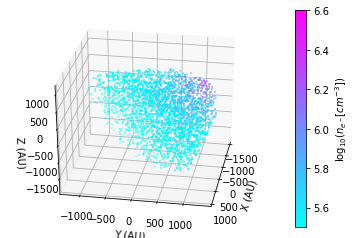

scatter3D is done!
-------------------------------------------------
-------------------------------------------------
Plotting 3D model with 2000 random-weighted points...
3D camera azimuth: 10.0 deg
3D camera elevation: 30.0 deg
Image saved as global_gridB.png
Ellapsed time from scatter3D: 2.35 s
Showing computed image...


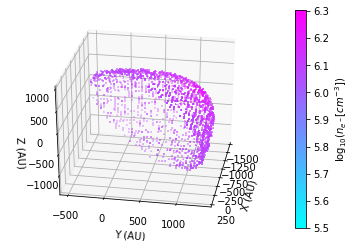

scatter3D is done!
-------------------------------------------------
-------------------------------------------------
Plotting 3D model with 4000 random-weighted points...
3D camera azimuth: 10.0 deg
3D camera elevation: 30.0 deg
Image saved as global_gridC.png
Ellapsed time from scatter3D: 2.70 s
Showing computed image...


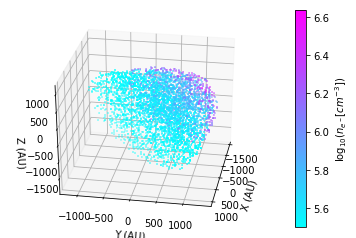

scatter3D is done!
-------------------------------------------------
-------------------------------------------------


In [10]:
#**********************************                                                                                                                                                  
#GRID POINTS 3-D PLOTTING                                                                                                                                                            
#**********************************                                                                                                                                                  
if plot_3d:
    tags = iter(['A','B','C'])
    npoints = iter([3000,2000,4000])
    for density in [prop_globalA['dens_e'], prop_globalB['dens_e'], prop_globalC['dens_e']]:
        dens2plot = density/1e6
        weight = 10*np.mean(dens2plot)
        Pm.scatter3D(GRID, dens2plot, weight,
                     NRand = next(npoints), axisunit = u.au,
                     colorscale = 'log',
                     cmap = 'cool',
                     colorlabel = r'${\rm log}_{10}(n_{e^-} [cm^{-3}])$',
                     output = 'global_grid%s.png'%next(tags),
                     vmin = 5.5,
                     azim = 10,
                     elev = 30,
                     show = True)


### Plotting the resulting SEDs

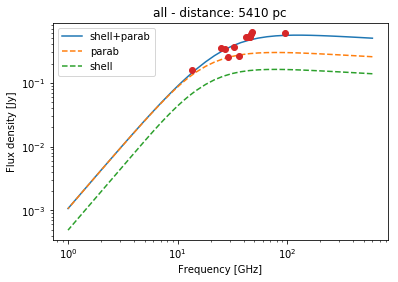

In [11]:
runpy.run_path('plot_sed_data.py');

### Let's compute the images at 45 and 95 GHz (and their beam convolution) and do some cleaning

In [12]:
runpy.run_path('generate_fits.py')
print ('-------------------------------------------------\n-------------------------------------------------')

print("Creating folder radmc3d_inp/")
cmd_call('mkdir radmc3d_inp')
print("Moving *.inp files to radmc3d_inp/")
cmd_call('mv *.inp radmc3d_inp')

print("Creating folder radmc3d_out/")
cmd_call('mkdir radmc3d_out')
print("Moving *.out files to radmc3d_out/")
cmd_call('mv *.out radmc3d_out')

print("\n*** Convolution ***\n")
cmd_call('python3 convolve_fits.py -freq 45')
cmd_call('python3 convolve_fits.py -freq 95')

print("Moving *.fits files to data/")
cmd_call('mv *.fits data')

-------------------------------------------------
-------------------------------------------------
Creating folder radmc3d_inp/
Moving *.inp files to radmc3d_inp/
Creating folder radmc3d_out/
Moving *.out files to radmc3d_out/

*** Convolution ***

Moving *.fits files to data/


0

## Plotting the synthetic images

Bottom row: 45 (left) and 95 GHz convolved synthetic images

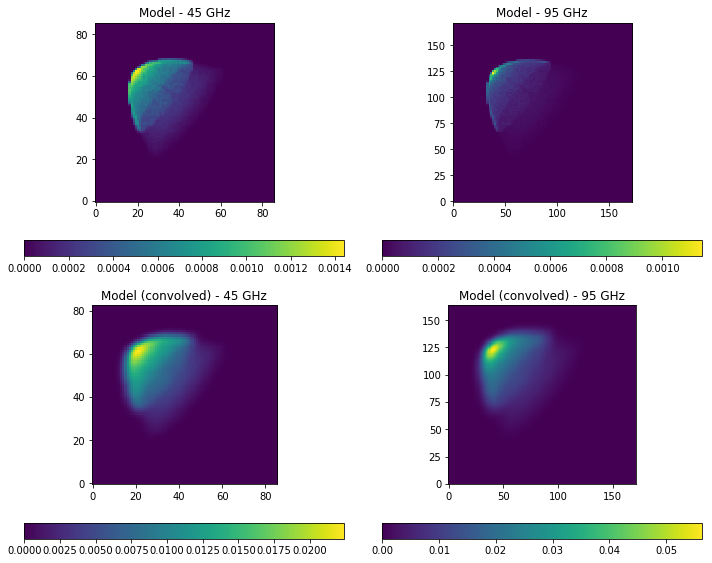

In [13]:
folder = './data/'

tags = ['%dghz.fits', '%dghz-conv.fits']
synt45 = [fits.open(folder+'image_'+tag%45)[0] for tag in tags] #45 GHz
synt95 = [fits.open(folder+'image_'+tag%95)[0] for tag in tags] #95 GHz
 #95 GHz

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))
ax[0][0].set_title('Model - 45 GHz')
ax[0][1].set_title('Model - 95 GHz')
ax[1][0].set_title('Model (convolved) - 45 GHz')
ax[1][1].set_title('Model (convolved) - 95 GHz')
for i in range(2): ax[i][0].imshow(synt45[i].data.squeeze(), origin='lower')
for i in range(2): ax[i][1].imshow(synt95[i].data.squeeze(), origin='lower')
for axi in ax.flatten(): fig.colorbar(axi.images[0], ax=axi, orientation='horizontal')
fig.tight_layout()

## Intensity at the projected borders of the paraboloid (data)

The green curve is the guessed parabolic profile that reproduces the object 'arms' reasonably along the white trajectory. 

['analysis/parabola.py']
Image 45 GHz --> center cy,cx: ([62], [23]), position angle: 225.0 deg
Image 95 GHz --> center cy,cx: ([127], [41]), position angle: 225.0 deg


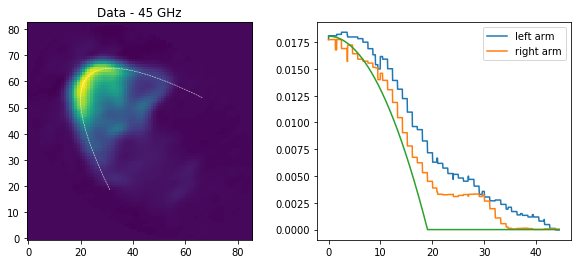

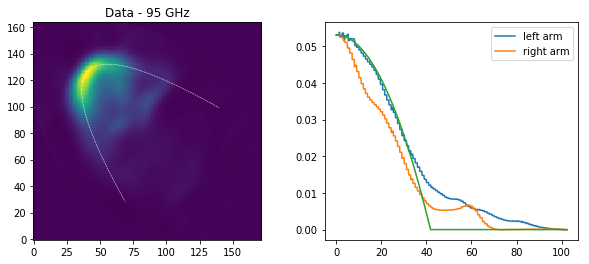

In [14]:
%run analysis/parabola.py

### Intensity at the projected borders of the paraboloid (model)

The green profile here has the same prescription as the one used for the data.

['analysis/parabola_model.py']
Image 45 GHz --> center cy,cx: ([62], [21]), position angle: 220.0 deg
Image 95 GHz --> center cy,cx: ([124], [41]), position angle: 220.0 deg


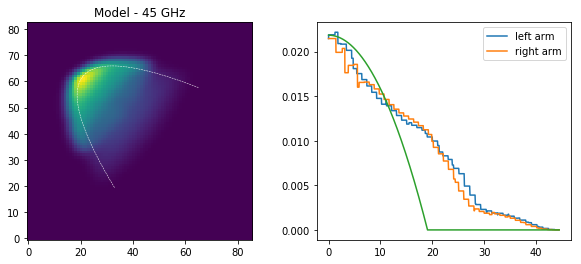

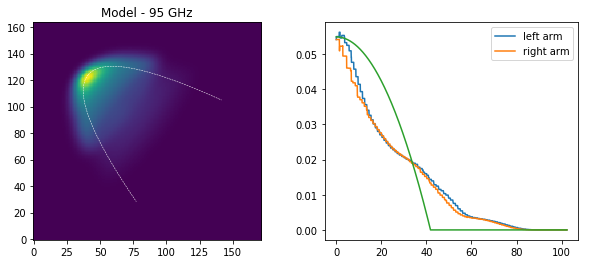

In [15]:
%run analysis/parabola_model.py

### Ionizing luminosity

From eq (13) of Vacca+1996, the hydrogen ionizing luminosity is given by
\begin{equation}
Q_0 = V_s n_{H}^2 \alpha_B
\end{equation}

In [16]:
from astropy import units as un

ind = prop_globalC['dens_ion'] > 1e3 #Reducing the cells domain
alpha_b = 2.6e-13*un.cm**3*un.s**-1 #Notes-on-Photoionized-Regions, Caltech, 2011                                                                                                    
Q = (alpha_b * (GRID.step*un.m)**3 * (prop_globalC['dens_ion']*un.m**-3)**2).decompose() #Eq. 13 Vacca+1996                                                                  
Q0 = Q[ind].sum()
print('log10 of the ionizing luminosity Q [photons s^-1]:', np.log10(Q0.value))

print("Ellapsed time from master: %.2f s"%(time.time()-t0))
print ('-------------------------------------------------\n-------------------------------------------------')

log10 of the ionizing luminosity Q [photons s^-1]: 48.327268558976364
Ellapsed time from master: 248.75 s
-------------------------------------------------
-------------------------------------------------


The obtained $Q_0$ leads to conclude that the ionizing source is a B0 or O9.5 star, according to the Tables 5-7 in Vacca+1996.

Adam's idea: compute the source location ($x_0,y_0,z_0$) using $Q_i$ and $Q_0$. The eq. to minimise would be:

\begin{equation}
\sum_{i=1}^{n} \left(Q_i - \beta \frac{Q_0 dV}{4\pi r_{0i}^2 dr} \right)^2 = 0
\end{equation}

where $dV = dxdydz$, $dr\approx dx$ and $r_{0i}=||\vec{r}_0-\vec{r}_i||$ is the distance from the source to the i-th cell. Minimise for $\vec{r}_0$.

$\beta$ is an attenuation factor such that:

\begin{equation}
\sum_{i=1}^{n} \beta \frac{Q_0 dV}{4\pi r_{0i}^2 dr} = Q_0 \\
\iff \beta  = \frac{1}{\frac{dV}{dr}\sum_{i=1}^{n} \frac{1}{4\pi r_{0i}^2}}
\end{equation}



In [17]:
dx = dy = dz = GRID.step
dxdy = dx*dy
#dxdydz = dx*dy*dz   
#dr = np.linalg.norm([dx,dy,dz])
fourpi = 4*np.pi
xi,yi,zi = GRID.XYZ

ri = np.array(zip(xi[ind],yi[ind],zi[ind])) 
def func_minimise(r0):
    r0 = np.asarray(r0)
    r0i = np.linalg.norm([ri[:,i] - r0[i] for i in range(3)], axis=0)
    ind0 = r0i == 0.0
    term2 = dxdy/(fourpi*r0i[~ind0]**2)
    beta = 1/np.sum(term2)
    f2min = ((Q[ind][~ind0].value - beta*Q0.value*term2)**2)#.decompose()
    return f2min.sum()**0.5

rand_ind = np.random.choice(np.arange(ri.shape[0]), ri.shape[0]/2) #Less cells, just to fasten the output, pick them randomly
r0 = ri #[rand_ind]
res = np.array([func_minimise(r) for r in r0])



## Plotting the best locations

In the block below I'm getting the ``n`` best source locations (n lowest ``res`` values) projected on the xy plane.

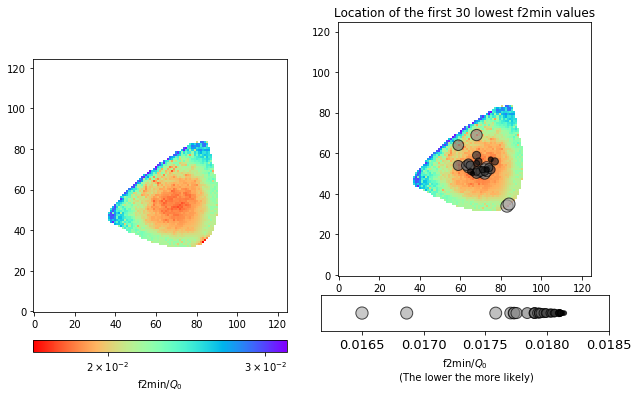

In [18]:
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

def get_stars(a,n):
    ind_ij = lambda ind: np.unravel_index(ind, a.shape)
    inds = [ind_ij(ind) for ind in np.argsort(a, axis=None)[:n]]
    vals = [a[ind] for ind in inds]
    sizes = np.linspace(150,20,n)
    colors = np.ones(3)*np.linspace(0.7,0.,n)[np.newaxis].T
    return np.array(inds), sizes, colors, vals

def plot_sub_axes(fig,sizes,colors,vals):
    axes_s = fig.add_axes([0.525, 0.25, 0.4, 0.05])
    axes_s.tick_params(labeltop=0,left=0,labelleft=0,labelbottom=1)
    axes_s.set_xlim(0.98*vals[0],1.02*vals[-1])
    axes_s.tick_params(labelsize = 13)
    axes_s.scatter(vals, np.zeros(len(sizes)), alpha = 0.7,
                   s = sizes, edgecolors = 'k', facecolor = colors)
    axes_s.set_xlabel('f2min/$Q_0$\n (The lower the more likely)')
    
dr = np.array([dx,dy,dz])
res_mat = np.zeros(GRID.Nodes)
nodes = np.asarray(GRID.Nodes)
for n,r in enumerate(r0):
    i,j,k = ( nodes // 2 + r0[n]/dr).astype('int')
    res_mat[i,j,k] = res[n]
res_mat=np.ma.masked_where(res_mat==0,res_mat)
res_min_z = np.min(res_mat, axis=2)

fig, ax = plt.subplots(ncols = 2, figsize = (10,10))
for i in range(2): ax[i].imshow(res_min_z/Q0, origin='lower', cmap='rainbow_r', norm=LogNorm())
cbar = fig.colorbar(ax[0].images[0], ax = ax[0], orientation='horizontal', pad=0.05)
cbar.set_label(r'f2min/$Q_0$')

nstars = 30
ind_min_val, sizes, colors, res_vals = get_stars(res_min_z/Q0,nstars) 
ax[1].set_title('Location of the first %d lowest f2min values' %nstars)
ax[1].scatter(ind_min_val[:,1], ind_min_val[:,0], 
              marker='o', edgecolor='k', alpha = 0.7,
              s=sizes,facecolor=colors)
plot_sub_axes(fig, sizes, colors, res_vals)
#r0[ res == res_mat[res_mat==res_min_z[ind_min_val]]]


## Using fmin from scipy.optimize 

fmin leads to similar results. However, this method is tricky as there are many local minima, it's therefore highly depending on the initial guess. 

Optimization terminated successfully.
         Current function value: 18215612209439838647995587182454512847868133376.000000
         Iterations: 158
         Function evaluations: 362
(15625,) (125, 125) [0 1]


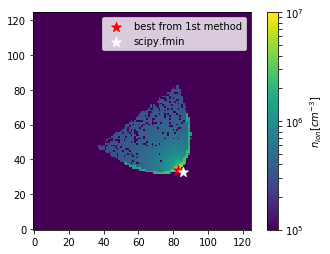

In [19]:
from matplotlib.colors import LogNorm
import sf3dmodels.Plot_model as Pm

from scipy.optimize import fmin
rmin = fmin(func_minimise, np.array([-3000,3000,0])*u.au.to('m'), maxiter=10000)

prop2d = Pm.plane2D(GRID, prop_globalC['dens_ion'], plane = {'z': 0}, auto=False)
plt.imshow(prop2d/1e6, norm=LogNorm(vmin=1e5, vmax=1e7), origin='lower')
plt.colorbar(label='$n_{ion}[cm^{-3}]$')

plt.scatter(prop2d.shape[0]//2 + r0[np.argmin(res)][1]/dy, 
            prop2d.shape[1]//2 + r0[np.argmin(res)][0]/dx,
            marker='*', color='red', s=100, label='best from 1st method')

plt.scatter(prop2d.shape[0]//2 + rmin[1]/dy, 
            prop2d.shape[1]//2 + rmin[0]/dx,
            marker='*', color='white', s=100, label='scipy.fmin')
plt.legend()
plt.show()
